### Read in RPi video for led sync test

In [1]:
import os
import numpy as np
import skvideo.io
from glob import glob

# base_path = '/n/groups/datta/Jonah/Rpi_test/20210610_rpi' # run on vncserver, has clock drift betw rpi and OE
base_path = '/n/groups/datta/Jonah/Rpi_test/20210611' # run on PutTty, hopefully no drift?
rpi_vid_path = glob('%s/*.mp4' % base_path )[0]
rpi_vid = skvideo.io.vread(rpi_vid_path, num_frames = 600)

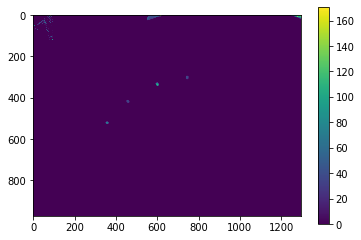

In [2]:
import matplotlib.pyplot as plt
std = np.std(rpi_vid[:,:,:,2], axis=0)
mean = np.mean(rpi_vid[:,:,:,2], axis=0)
plt.imshow(mean)
plt.colorbar()


In [3]:
import skvideo.io
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from skimage.feature import canny

stdpx = np.std(rpi_vid[:,:,:,2], axis=0)

## threshold the image to get rid of edge noise:
thresh = threshold_otsu(stdpx)
thresh_px = np.copy(stdpx)
thresh_px[thresh_px<thresh] = 0

edges = canny(thresh_px/255.) ## find the edges
filled_image = ndi.binary_fill_holes(edges) ## fill its edges
labeled_leds, num_features = ndi.label(filled_image) ## get the clusters
print(num_features)

4


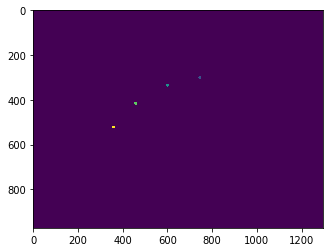

In [4]:
plt.imshow(labeled_leds)

In [98]:
labels = [label for label in np.unique(labeled_leds) if label > 0 ]
            
## get LED x and y positions for sorting
leds_xs = [np.where(labeled_leds==i)[1].mean() for i in labels] 
leds_ys = [np.where(labeled_leds==i)[0].mean() for i in labels] 
# sorting = np.argsort(leds_xs)
sorting = np.array([0, 1, 2, 3])

In [159]:
vid_reader = skvideo.io.FFmpegReader(rpi_vid_path)
(totalFrames, _, _, _) = vid_reader.getShape()
vid_reader.close()
videogen = skvideo.io.vreader(rpi_vid_path)
led_vals = np.zeros((totalFrames,4))
for i,frame in enumerate(videogen):
    for j in range(len(sorting)):
        led_num = sorting[j]
        led_vals[i,j] = frame[round(leds_ys[led_num]).astype('int'), round(leds_xs[led_num]).astype('int'), 2]

(-1, 1)

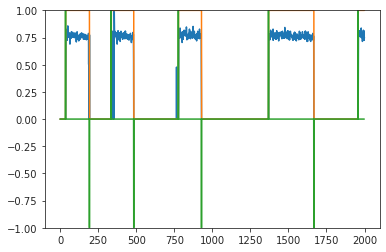

In [198]:

# ch = 0
# slc = slice(13000,15000)
# convolved = np.convolve(led_vals[:,ch], np.ones((factor,)), mode='same')/factor
# # plt.plot(convolved[slc])
# on_or_off = convolved > np.mean(convolved)
# plt.figure()
# plt.plot(led_vals[slc,ch]/np.max(led_vals[:,ch]))
# plt.plot(on_or_off[slc])
# plt.plot(np.diff(on_or_off[slc].astype('int')))
# plt.ylim((-1,1))


In [204]:
leds = []
led_thresh = 0.5
for i in range(4):
    led_vec = np.zeros(totalFrames)
    signal = led_vals[:,i]
    convolved = np.convolve(signal, np.ones((factor,)), mode='same')/factor
    on_or_off = (convolved > np.mean(convolved)).astype('int') # 0 or 1
    led_on = np.where(np.diff(on_or_off) > 0.5)[0]   #rise indices
    led_off = np.where(np.diff(on_or_off) < -0.5)[0]   #fall indic
    led_vec[led_on] = 1
    led_vec[led_off] = -1
    leds.append(led_vec)
leds = np.vstack(leds) #spiky differenced signals to extract times  

In [217]:
np.where(leds)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([  565,   718,  1305,  2199,  2645,  2794,  3386,  3535,  4274,
         4867,  5455,  5608,  5752,  6346,  6792,  6940,  7087,  7237,
       

### Get Rpi timestamps

In [11]:
import pandas as pd
rpi_ts_path = '%s/rpicamera_video_timestamps.csv' % base_path
rpi_ts = np.genfromtxt(rpi_ts_path, delimiter=',')
rpi_ts # col 1 is frame times, col 2 is times the rpi recorded itself sending a pulse to Open Ephys

array([[2.35132137e+09, 2.35137831e+09],
       [2.35135469e+09, 2.35140824e+09],
       [2.35138802e+09, 2.35143601e+09],
       ...,
       [2.85703439e+09, 2.85708852e+09],
       [2.85706772e+09, 2.85711786e+09],
       [2.85710105e+09, 2.85715110e+09]])

Text(0, 0.5, 'Difference (sec)')

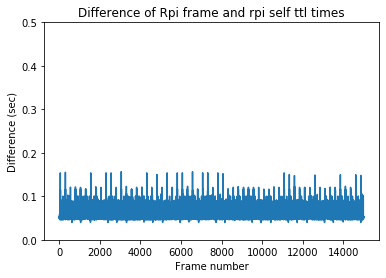

In [12]:
plt.plot(np.diff(rpi_ts, axis=1)/1e6)
plt.ylim((0,0.5)) 
plt.title('Difference of Rpi frame and rpi self ttl times')
plt.xlabel('Frame number')
plt.ylabel('Difference (sec)')

In [13]:
def interpolate_missing_timestamps(ts, fps=30):
    """simple interpolation of missing timestamps (not multiple in a row)
        Taken from Arne's github:
         https://github.com/arnefmeyer/RPiCameraPlugin/blob/master/Python/rpicamera/util.py
    """
    dt = 1. / fps
    missing = np.where(ts < 0)[0]
    for i in missing:

        if i == 0:
            ts[i] = ts[i+1] - dt
        else:
            ts[i] = ts[i-1] + dt

    return ts

Text(0, 0.5, 'Difference (sec)')

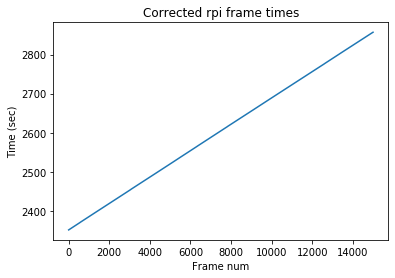

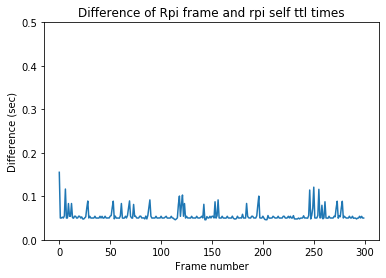

In [14]:
true_fps = totalFrames / (rpi_ts[0,0] - rpi_ts[-1,0])
orig_rpi_ts = rpi_ts.copy()
rpi_ts[:,0] = interpolate_missing_timestamps(rpi_ts[:,0], fps=true_fps)
rpi_ts[:,0] = interpolate_missing_timestamps(rpi_ts[:,0], fps=true_fps)
plt.plot(rpi_ts[:,0]/1e6)
plt.xlabel('Frame num')
plt.ylabel('Time (sec)')
plt.title('Corrected rpi frame times')

plt.figure()
diffs = np.diff(rpi_ts, axis=1)/1e6
plt.plot(diffs[300:600])
plt.ylim((0,0.5)) 
plt.title('Difference of Rpi frame and rpi self ttl times')
plt.xlabel('Frame number')
plt.ylabel('Difference (sec)')

Text(0.5, 1.0, 'Inter-TTL intervals')

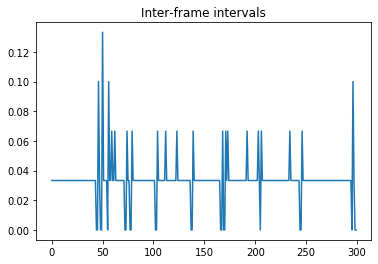

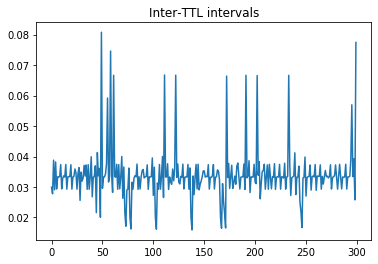

In [15]:
plt.figure()
frame_diffs = np.diff(rpi_ts[:,0]/1e6)
plt.plot(frame_diffs[0:300])
plt.title('Inter-frame intervals')


plt.figure()
ttl_diffs = np.diff(rpi_ts[:,1]/1e6)
plt.plot(ttl_diffs[0:300])
plt.title('Inter-TTL intervals')

### Use Rpi frame times to generate LED events list (just for sync testing purposes)

In [209]:
from moseq2_ephys_sync.extract_leds import gen_batch_sequence, get_led_data, get_events

rpi_frame_ts = (rpi_ts[:,0] - rpi_ts[0,0]) /1e6 # start at 0 and convert to sec
rpi_self_ttl_ts = (rpi_ts[:,1] - rpi_ts[0,0]) /1e6 # start at 0 of the frame index, convert to sec
rpi_led_events = get_events(leds, rpi_frame_ts, time_offset=0, num_leds=4)

In [210]:
rpi_led_events # frame time, channel, on (1) or off (-1)

array([[  4.132624,   2.      ,   1.      ],
       [  4.132624,   3.      ,   1.      ],
       [  8.998454,   3.      ,  -1.      ],
       [  9.031782,   1.      ,  -1.      ],
       [ 14.06425 ,   3.      ,   1.      ],
       [ 19.263357,   1.      ,   1.      ],
       [ 19.263357,   2.      ,  -1.      ],
       [ 19.263357,   0.      ,   1.      ],
       [ 19.296687,   3.      ,  -1.      ],
       [ 24.295828,   3.      ,   1.      ],
       [ 24.362481,   2.      ,   1.      ],
       [ 24.362481,   0.      ,  -1.      ],
       [ 29.294967,   3.      ,  -1.      ],
       [ 34.327434,   3.      ,   1.      ],
       [ 34.360762,   1.      ,  -1.      ],
       [ 39.193265,   1.      ,   1.      ],
       [ 39.226593,   3.      ,  -1.      ],
       [ 43.459198,   2.      ,  -1.      ],
       [ 43.492528,   2.      ,   1.      ],
       [ 43.559181,   2.      ,  -1.      ],
       [ 43.625836,   2.      ,   1.      ],
       [ 44.192406,   2.      ,  -1.      ],
       [ 4

### Use RPi self ttl times to compare with OE TTL times (general use case)

In [211]:
ephys_fs = 3e4
ephys_ttl_path = glob('%s/**/TTL_*/' % base_path,recursive = True)[0]
channels = np.load('%s/channel_states.npy' % ephys_ttl_path)
ephys_timestamps = np.load('%s/timestamps.npy' % ephys_ttl_path) / ephys_fs # in seconds
print('Assuming rpi ttl is in ttl channel 7...')
rpi_oe_ttl_bool = np.isin(channels, [-7,7])
rpi_oe_ttl_events = np.vstack([ephys_timestamps[rpi_oe_ttl_bool], channels[rpi_oe_ttl_bool], np.sign(channels[rpi_oe_ttl_bool])]).T


Assuming rpi ttl is in ttl channel 7...


In [29]:
np.max(ephys_timestamps) - np.min(ephys_timestamps)

505.76853333333327

In [46]:
ephys_timestamps.shape

(30254,)

In [58]:
np.max(rpi_self_ttl_ts) - np.min(rpi_self_ttl_ts)

0.0

In [19]:
# As Arne notes, there are a few extra times in the RPi's file
# See here: https://github.com/arnefmeyer/IMUReaderPlugin
rising_bool = rpi_oe_ttl_events[:,2]==1
print(rpi_oe_ttl_events[rising_bool].shape)
print(rpi_self_ttl_ts.shape)

(15000, 3)
(15000,)


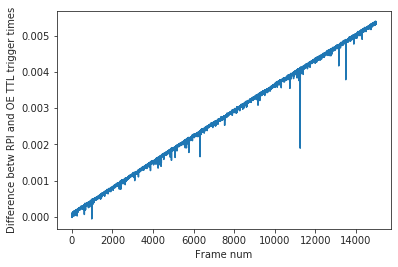

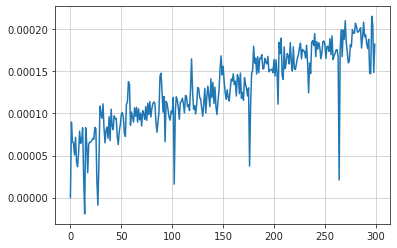

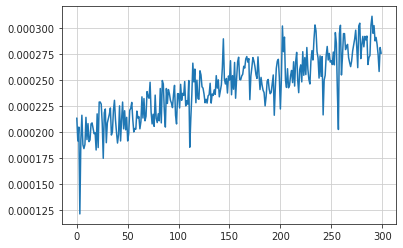

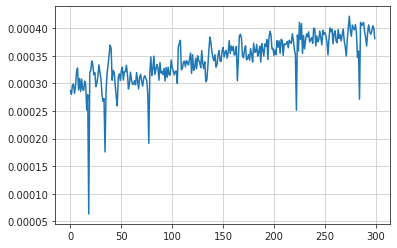

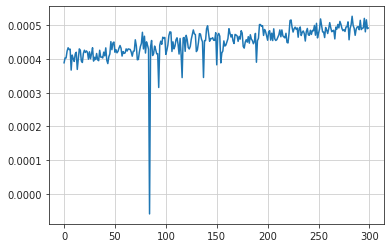

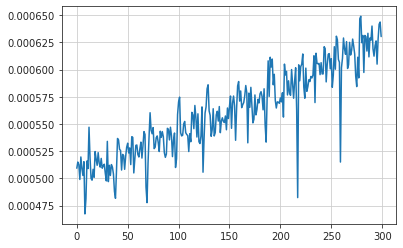

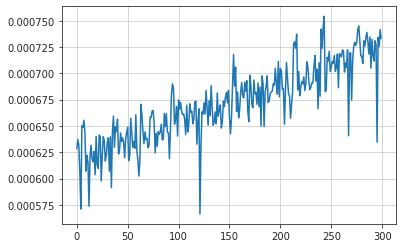

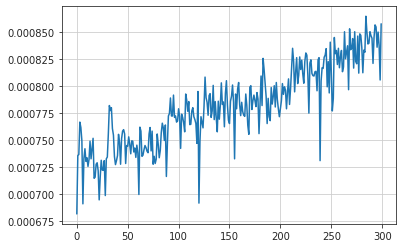

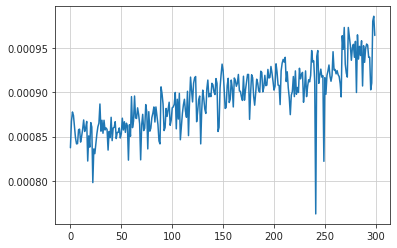

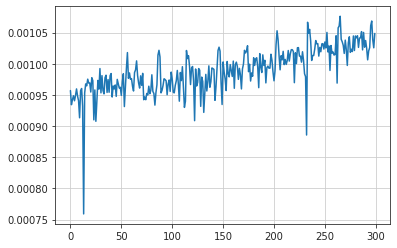

In [20]:
zeroed_oe_rpi_ttl = rpi_oe_ttl_events[rising_bool,0] - rpi_oe_ttl_events[0,0]
# extra_rpi_ts = rpi_self_ttl_ts.shape[0] - rpi_oe_ttl_events[rising_bool].shape[0]
# plt.plot(rpi_self_ttl_ts[:(-1*extra_rpi_ts)] - zeroed_oe_rpi_ttl)
plt.plot(rpi_self_ttl_ts - zeroed_oe_rpi_ttl)
plt.xlabel('Frame num')
plt.ylabel('Difference betw RPI and OE TTL trigger times')

step = 300
for i in range(9):
    plt.figure()
    diffs = rpi_self_ttl_ts[(step*i):(step*(i+1))] - zeroed_oe_rpi_ttl[(step*i):(step*(i+1))]
#     diffs[diffs < np.percentile(diffs,1)] = np.NaN
    plt.plot(diffs)
    plt.grid()

Hmm, that's not good. The difference between the RPI and OE TTL trigger times should be flat over the session. If not, there's error accumulating somewhere...20 ms by the end of a 15-min session is large enough that this requires fixing!

Looks like there's something funny going on every ~30th frame...

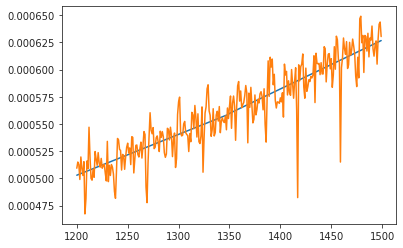

In [56]:
idx = slice(1200, 1500)
plt.plot(xvals[idx], fit[idx])
plt.plot(xvals[idx], diffs[idx])

Text(0, 0.5, 'Cross corr')

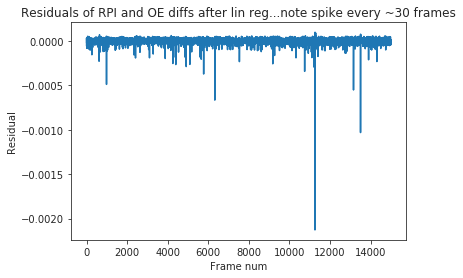

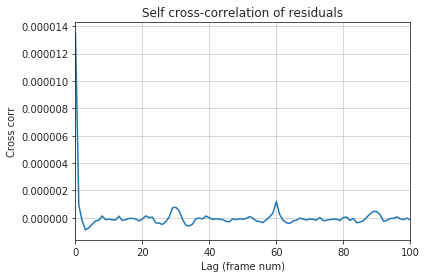

In [57]:
from scipy.signal import correlate
from scipy.stats import linregress # wow finally a simple linear reg tool
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer

# It's actually not quite linear...let's bin it
# diffs = rpi_self_ttl_ts - zeroed_oe_rpi_ttl
# xvals = np.arange(0,len(diffs),1)
# lr = linregress(xvals, diffs)
# fit_line = xvals*lr.slope + lr.intercept
# sub_diffs = diffs - fit_line
# # plt.figure()
# # plt.plot(sub_diffs)
# plt.figure()
# plt.plot(sub_diffs[0:300])
# plt.title('Residuals of RPI and OE diffs after lin reg...note spike every ~30 frames')
# plt.xlabel('Frame num')
# plt.ylabel('Residual')

xvals = np.arange(0,len(diffs),1)
diffs = rpi_self_ttl_ts - zeroed_oe_rpi_ttl
diffs_model = PiecewiseRegressor(verbose=False, binner=KBinsDiscretizer(n_bins=round(len(diffs)/150)))
diffs_model.fit(xvals.reshape(-1,1), diffs)
fit = diffs_model.predict(xvals.reshape(-1,1))
sub_diffs = diffs - fit
plt.figure()
plt.plot(sub_diffs)
plt.title('Residuals of RPI and OE diffs after lin reg...note spike every ~30 frames')
plt.xlabel('Frame num')
plt.ylabel('Residual')

cx = correlate(sub_diffs,sub_diffs)
lags = np.arange(-1*len(sub_diffs) + 1, len(sub_diffs))
plt.figure()
plt.plot(lags, cx)
plt.title('Self cross-correlation of residuals')
# plt.xlim((2240,2260))
plt.xlim((0,100))
plt.grid()
plt.xlabel('Lag (frame num)')
plt.ylabel('Cross corr')

Indeed! Given that we're filming at ~30 fps, this is suspicious...

### Investigate the drift between RPI and OE TTL

In [23]:
# Q: Could it be caused by the skipped frames in the RPI?
# A: doesn't look like it. The error is accumulating ms by ms, not stepwise around the dropped frames
skip_idx = np.where(orig_rpi_ts < 0)[0]
for i in range(len(skip_idx)):
    plt.figure()
    slc = slice((skip_idx[i]-300), (skip_idx[i]+300))
    plt.plot(rpi_self_ttl_ts[slc] - zeroed_oe_rpi_ttl[slc])

In [24]:
plt.close('all')

### Use TTLs to align RPI and OE time

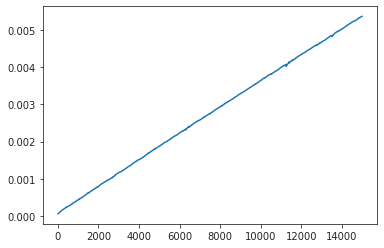

In [80]:
plt.plot(diffs)

In [212]:
# oe time = rpi time - fit diffs
# rpi_led_events
diffs = diffs_model.predict(xvals.reshape(-1,1))
rpi_frame_times_in_oe_time = rpi_frame_ts - diffs
rpi_oe_led_events = get_events(leds, rpi_frame_times_in_oe_time, time_offset=0, num_leds=4)
rpi_oe_led_events

array([[  4.13250502,   2.        ,   1.        ],
       [  4.13250502,   3.        ,   1.        ],
       [  8.99827408,   3.        ,  -1.        ],
       [  9.03160168,   1.        ,  -1.        ],
       [ 14.06401286,   3.        ,   1.        ],
       [ 19.26308155,   1.        ,   1.        ],
       [ 19.26308155,   2.        ,  -1.        ],
       [ 19.26308155,   0.        ,   1.        ],
       [ 19.2964113 ,   3.        ,  -1.        ],
       [ 24.29549417,   3.        ,   1.        ],
       [ 24.36214636,   2.        ,   1.        ],
       [ 24.36214636,   0.        ,  -1.        ],
       [ 29.29458278,   3.        ,  -1.        ],
       [ 34.32699255,   3.        ,   1.        ],
       [ 34.36032019,   1.        ,  -1.        ],
       [ 39.19277733,   1.        ,   1.        ],
       [ 39.22610498,   3.        ,  -1.        ],
       [ 43.45866319,   2.        ,  -1.        ],
       [ 43.49199282,   2.        ,   1.        ],
       [ 43.55864506,   2.     

In [213]:
ephys_ttl_path = glob('%s/**/TTL_*/' % base_path,recursive = True)[0]
channels = np.load('%s/channel_states.npy' % ephys_ttl_path)
ephys_fs = 3e4
ephys_timestamps = np.load('%s/timestamps.npy' % ephys_ttl_path)
ephys_timestamps = (ephys_timestamps - ephys_timestamps[0])/ephys_fs
led_fs = 30
led_interval = 5 # seconds

print('Assuming LED events in TTL channels 1-4...')
ttl_channels = [-4,-3,-2,-1,1,2,3,4]
ttl_bool = np.isin(channels, ttl_channels)
ephys_events = np.vstack([ephys_timestamps[ttl_bool], abs(channels[ttl_bool])-1, np.sign(channels[ttl_bool])]).T
ephys_events

Assuming LED events in TTL channels 1-4...


array([[  2.09646667,   0.        ,  -1.        ],
       [  2.09646667,   3.        ,  -1.        ],
       [  7.09856667,   3.        ,   1.        ],
       [ 12.10076667,   1.        ,  -1.        ],
       [ 12.10076667,   2.        ,   1.        ],
       [ 12.10076667,   3.        ,  -1.        ],
       [ 17.10293333,   0.        ,   1.        ],
       [ 17.10293333,   1.        ,   1.        ],
       [ 17.10293333,   2.        ,  -1.        ],
       [ 17.10293333,   3.        ,   1.        ],
       [ 22.10386667,   0.        ,  -1.        ],
       [ 22.10386667,   3.        ,  -1.        ],
       [ 27.10493333,   3.        ,   1.        ],
       [ 32.10783333,   3.        ,  -1.        ],
       [ 37.10936667,   0.        ,   1.        ],
       [ 37.10936667,   2.        ,   1.        ],
       [ 37.10936667,   3.        ,   1.        ],
       [ 42.1122    ,   0.        ,  -1.        ],
       [ 42.1122    ,   1.        ,  -1.        ],
       [ 42.1122    ,   2.     

Assuming LED events in TTL channels 1-4...


/home/jop9552/miniconda3/envs/sync_test/lib/python3.7/site-packages/ipykernel-6.0.0rc0-py3.7.egg/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


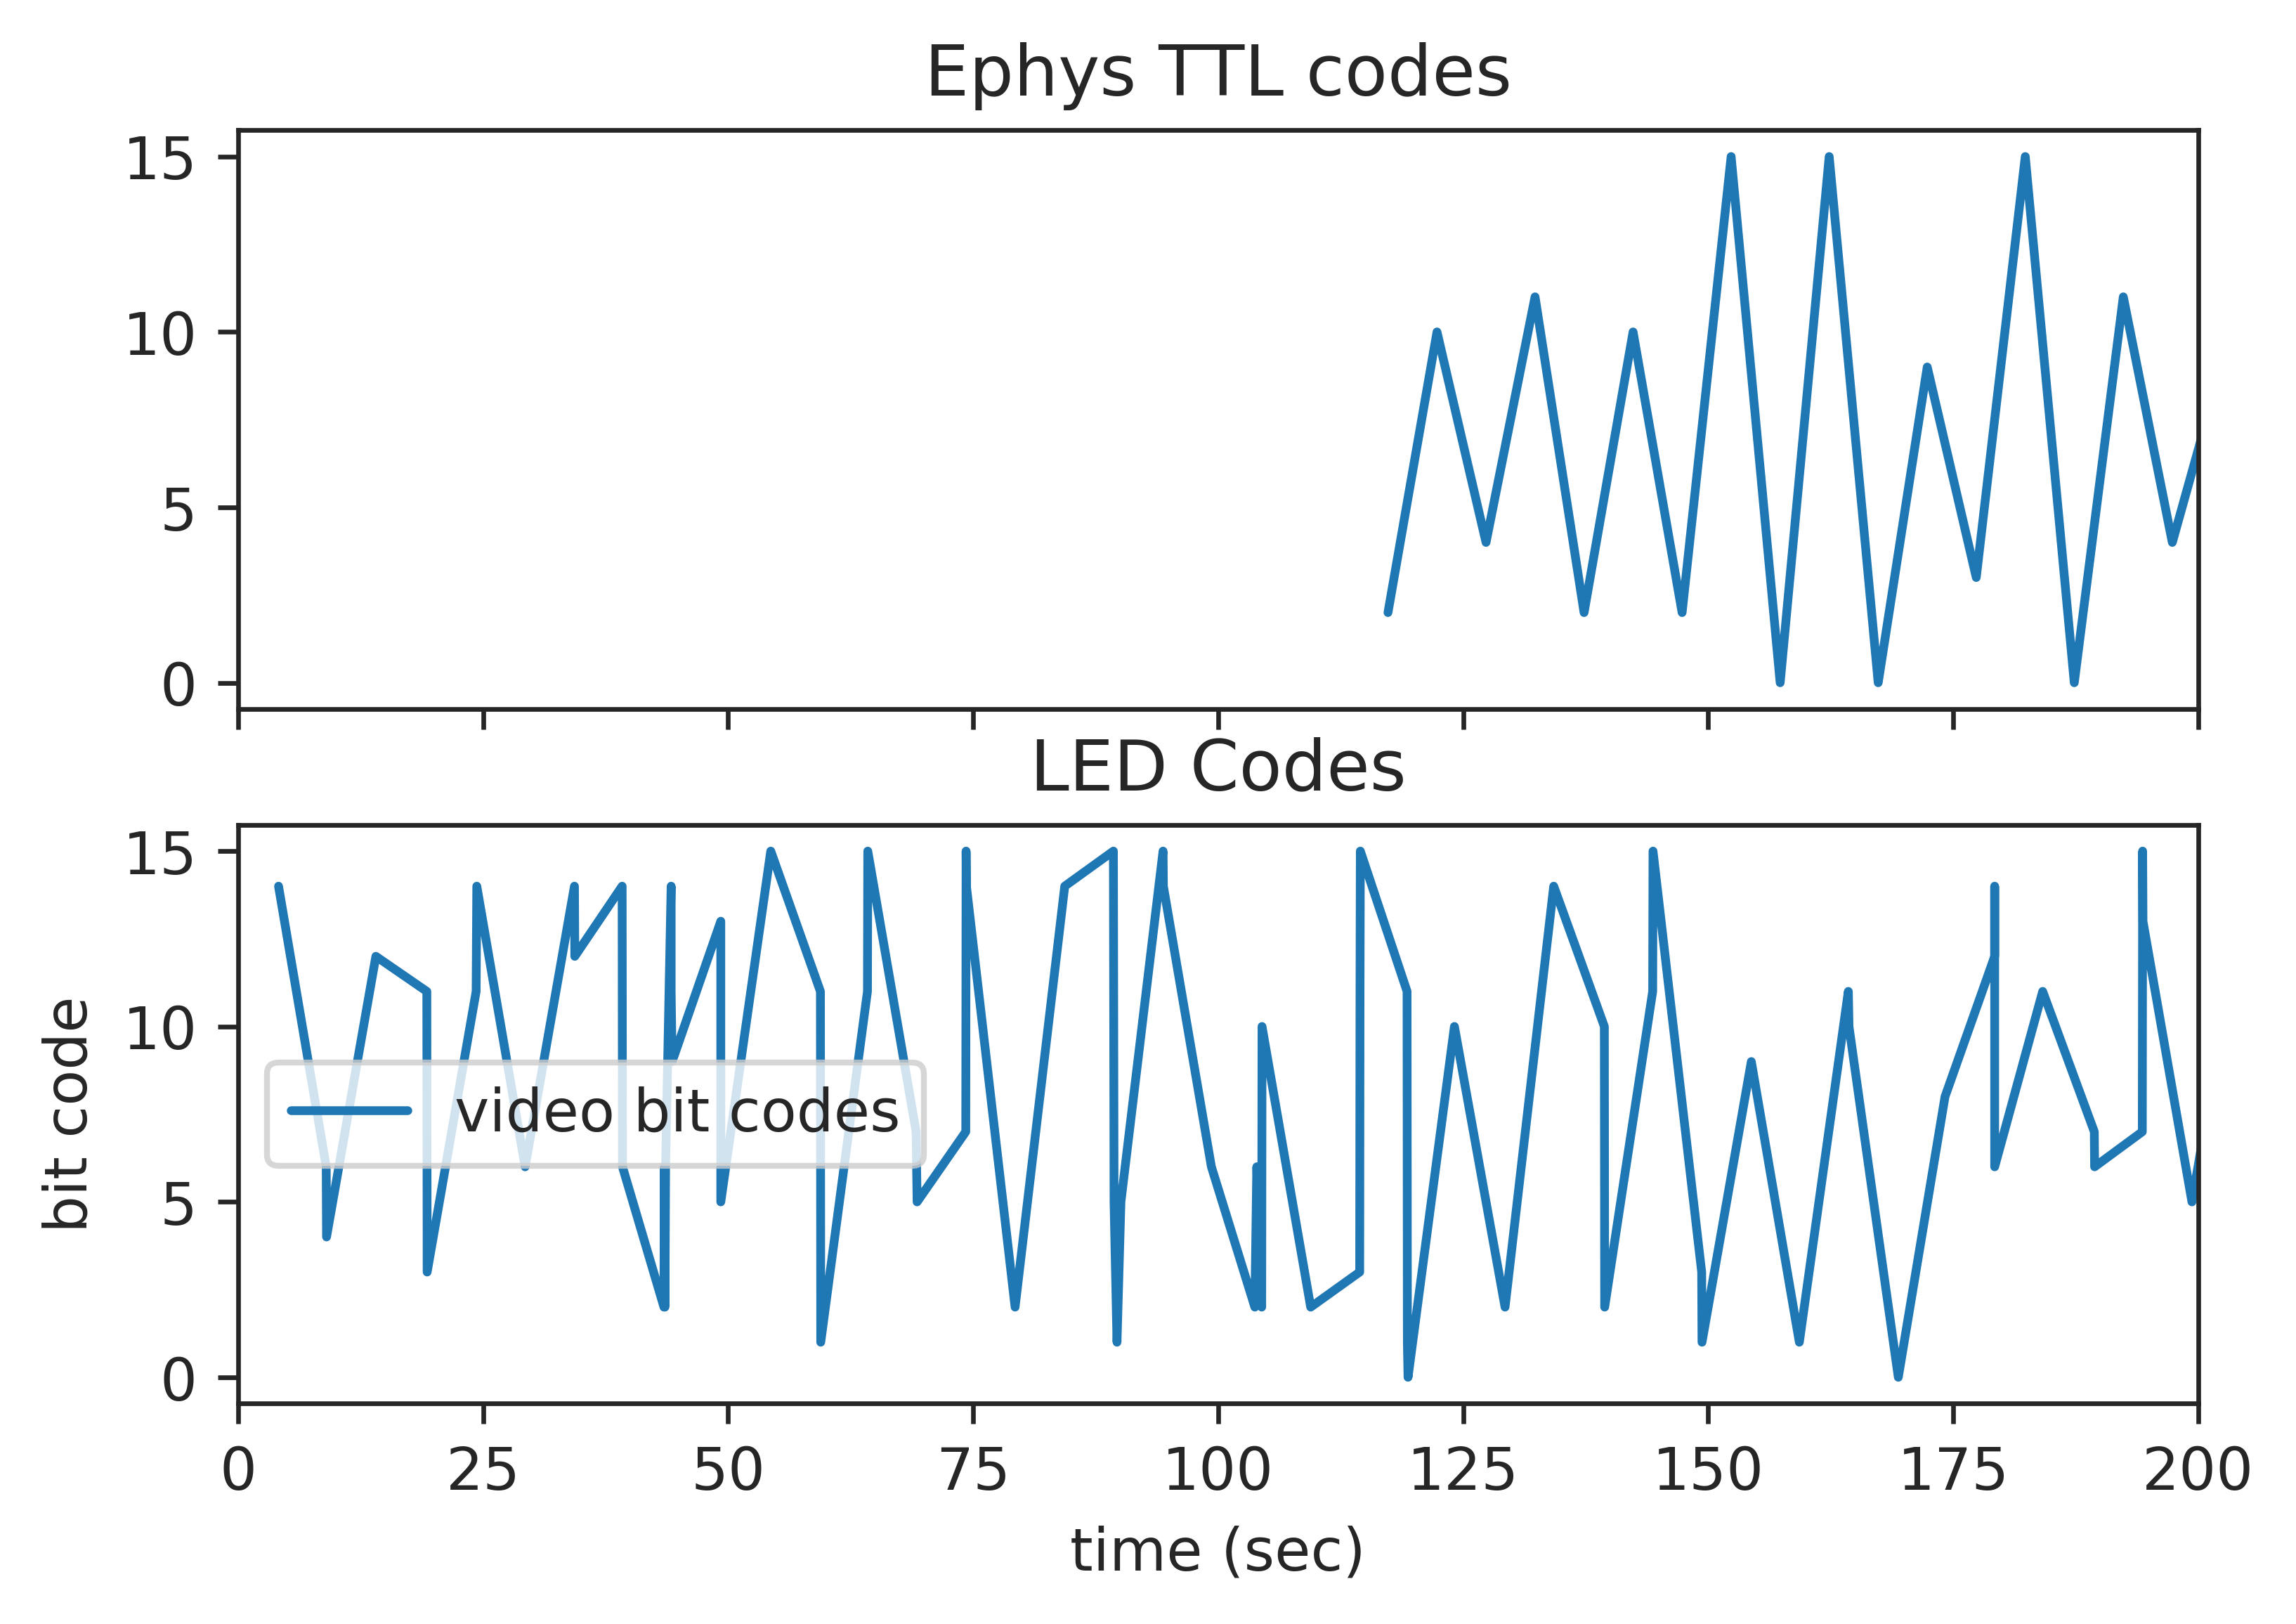

In [216]:
from moseq2_ephys_sync.sync import events_to_codes, match_codes
from moseq2_ephys_sync.plotting import plot_matched_scatter, plot_model_errors, plot_matches_video_time,plot_video_frame

def plot_code_chunk(ephys_codes,led_codes,ephys_fs):

    f,axarr = plt.subplots(2,1,dpi=600,sharex=True)

    axarr[0].plot(ephys_codes[:,0]/ephys_fs,ephys_codes[:,1],label='ephys bit codes')
    axarr[0].set_title('Ephys TTL codes')

    axarr[1].plot(led_codes[:,0],led_codes[:,1],label='video bit codes')
    axarr[1].set_title('LED Codes')

    plt.xlim([0,200])

    plt.xlabel('time (sec)')
    plt.ylabel('bit code')
    plt.legend()

    plt.show()
    
ephys_ttl_path = glob('%s/**/TTL_*/' % base_path,recursive = True)[0]
channels = np.load('%s/channel_states.npy' % ephys_ttl_path)
ephys_timestamps = np.load('%s/timestamps.npy' % ephys_ttl_path)
ephys_fs = 3e4

## convert the ephys TTL events to bit codes:
print('Assuming LED events in TTL channels 1-4...')
ttl_channels = [-4,-3,-2,-1,1,2,3,4]
ttl_bool = np.isin(channels, ttl_channels)
ephys_events = np.vstack([ephys_timestamps[ttl_bool], abs(channels[ttl_bool])-1, np.sign(channels[ttl_bool])]).T
ephys_codes, ephys_latencies = events_to_codes(ephys_events, nchannels=4, minCodeTime=(led_interval-1)*ephys_fs)
ephys_codes = np.asarray(ephys_codes)
# ephys_codes[:,0] = (ephys_codes[:,0] - ephys_codes[0,0])
rpi_codes, _ = events_to_codes(rpi_oe_led_events, nchannels=4, minCodeTime=0)
rpi_codes = np.asarray(rpi_codes)

plot_code_chunk(ephys_codes,rpi_codes,ephys_fs)



In [215]:
rpi_codes

array([[  4.13250502,  14.        ,   2.        ],
       [  8.99827408,   6.        ,   3.        ],
       [  9.03160168,   4.        ,   1.        ],
       [ 14.06401286,  12.        ,   3.        ],
       [ 19.26308155,  11.        ,   1.        ],
       [ 19.2964113 ,   3.        ,   3.        ],
       [ 24.29549417,  11.        ,   3.        ],
       [ 24.36214636,  14.        ,   2.        ],
       [ 29.29458278,   6.        ,   3.        ],
       [ 34.32699255,  14.        ,   3.        ],
       [ 34.36032019,  12.        ,   1.        ],
       [ 39.19277733,  14.        ,   1.        ],
       [ 39.22610498,   6.        ,   3.        ],
       [ 43.45866319,   2.        ,   2.        ],
       [ 43.49199282,   6.        ,   2.        ],
       [ 43.55864506,   2.        ,   2.        ],
       [ 43.62529931,   6.        ,   2.        ],
       [ 44.19186331,  14.        ,   3.        ],
       [ 44.19186368,  11.        ,   2.        ],
       [ 44.29184493,   9.     